In [26]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models import resnet18
import torch
import torchvision.transforms as transforms
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.optim as optim
from torch.utils.data import RandomSampler
import numpy  as np 
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

import string
import os
import shutil

import pandas as pd
import numpy as np
import random
from tabulate import tabulate
import matplotlib.pyplot as plt
from skimage import io
from scipy.stats import pearsonr


## Model Card

In [8]:
# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Define a function to count parameters
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable_params, non_trainable_params

# Initialize table data
table_data = []

# Dummy input with 3 channels (for RGB image)
dummy_input = torch.randn(1, 3, 224, 224)

# Iterate through model's children
for name, layer in model.named_children():
    # For convolutional layers, use dummy input to infer shapes
    if isinstance(layer, torch.nn.Conv2d):
        output_shape = tuple(layer(dummy_input).shape[1:])
    else:
        # For other layers, just use dummy input shape
        output_shape = tuple(dummy_input.shape[1:])

    # Get number of parameters
    num_params = count_parameters(layer)

    # Append layer information to table data
    table_data.append([name, str(layer.__class__.__name__), output_shape, num_params[0], num_params[1]])

# Print table
print(tabulate(table_data, headers=["Layer Name", "Layer Type", "Output Shape", "Trainable Params", "Non-trainable Params"]))

# Print total trainable and non-trainable params
total_trainable_params, total_non_trainable_params = count_parameters(model)
print("\nTotal Trainable Parameters:", total_trainable_params)
print("Total Non-trainable Parameters:", total_non_trainable_params)


Layer Name    Layer Type         Output Shape      Trainable Params    Non-trainable Params
------------  -----------------  --------------  ------------------  ----------------------
conv1         Conv2d             (64, 112, 112)                9408                       0
bn1           BatchNorm2d        (3, 224, 224)                  128                       0
relu          ReLU               (3, 224, 224)                    0                       0
maxpool       MaxPool2d          (3, 224, 224)                    0                       0
layer1        Sequential         (3, 224, 224)               147968                       0
layer2        Sequential         (3, 224, 224)               525568                       0
layer3        Sequential         (3, 224, 224)              2099712                       0
layer4        Sequential         (3, 224, 224)              8393728                       0
avgpool       AdaptiveAvgPool2d  (3, 224, 224)                    0             

## Sort out data from different sources

In [2]:
# import os
# import shutil

# # Path to the test data directory
# test_dir = 'data/test'

# # Iterate through the files in the test directory
# for filename in os.listdir(test_dir):
#     # Extract the label from the filename (assuming the label is the first character)
#     label = filename[0].lower()  # Assuming labels are lowercase letters
    
#     # Create the destination folder if it doesn't exist
#     dest_folder = os.path.join(test_dir, label)
#     if not os.path.exists(dest_folder):
#         os.makedirs(dest_folder)
    
#     # Check if the item is a file
#     src_path = os.path.join(test_dir, filename)
#     if os.path.isfile(src_path):
#         # Move the file to the destination folder
#         dest_path = os.path.join(dest_folder, filename)
#         shutil.move(src_path, dest_path)

# print("Test data organized into folders successfully.")


## Data Preprocessing - Model transform

In [10]:
root_dir = 'data/train'

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224x3 (3 for RGB)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("transforming data")
datasets = datasets.ImageFolder(root=root_dir, transform=transform)

transoforming data


## Train Val Test Split 

In [11]:
#split the dataset into train test val
train_test_val_split = [0.7, 0.15, 0.15]
# Use torch.utils.data.random_split to split the datasets into train, test, and validation sets
train_data, test_data, val_data = torch.utils.data.random_split(datasets,
                                    [round(p * len(datasets)) for p in train_test_val_split],
                                    generator=torch.Generator().manual_seed(42))

print(f"Training data length: {len(train_data)}, validation data length {len(val_data)}, test data length {len(test_data)}")

Training data length: 60900, validation data length 13050, test data length 13050


## Load the data

In [5]:
# create dataloader for each split
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=4)

## EDA

In [6]:
from torchvision import datasets, transforms
# Create the training dataset
train_dataset = datasets.ImageFolder(root=root_dir, transform=transform)
# Get the class names and the number of classes
class_names = train_dataset.classes  # Get the class names from the dataset
num_classes = len(class_names)  # Get the number of classes
print("Available classes:")
print(class_names)
print(num_classes)

Available classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
29


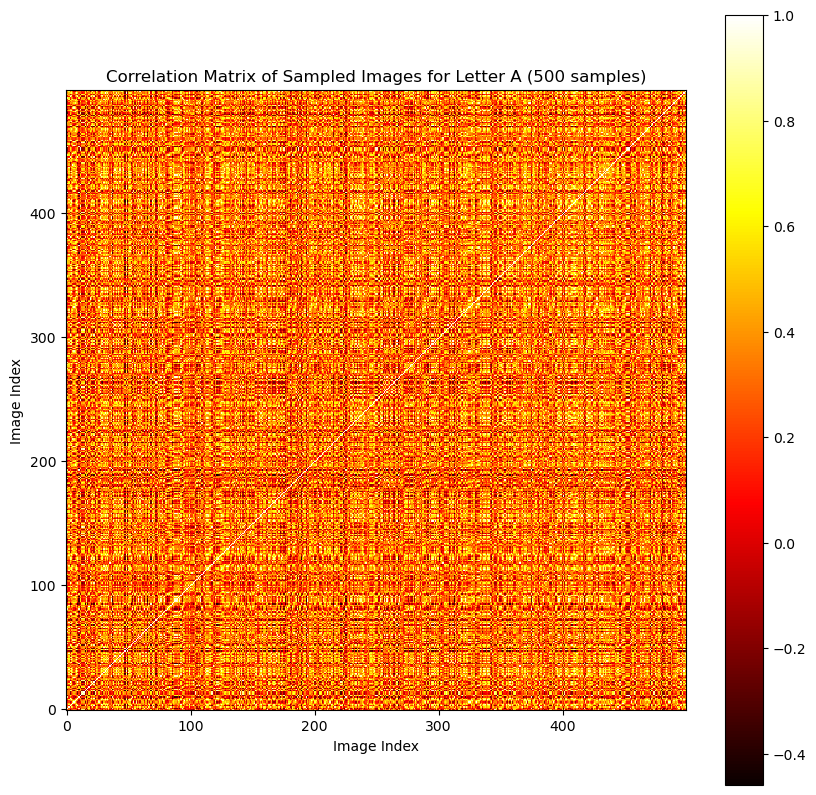

In [29]:
# Function to load images from folder A
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        images.append(img_path)
    return images

# Define the root directory for folder A
folder_A_dir = os.path.join(root_dir, 'A')

# Load images from folder A
images_in_folder_A = load_images_from_folder(folder_A_dir)

# Randomly sample 500 images
sampled_images = random.sample(images_in_folder_A, 500)

# Load images and flatten them
flattened_images = []
for img_path in sampled_images:
    img = io.imread(img_path, as_gray=True)
    flattened_images.append(img.flatten())

# Compute correlation matrix
correlation_matrix = np.corrcoef(flattened_images)

# Plot the heatmap
plt.figure(figsize=(10,10))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix of Sampled Images for Letter A (500 samples)')
plt.xlabel('Image Index')
plt.ylabel('Image Index')

# Reverse the y-axis ticks
plt.gca().invert_yaxis()

plt.show()


## Set device to GPU 

In [7]:
# use gpu if possible
device = 'cpu'
device = torch.device("cuda:0" if torch.cuda.is_available() else device)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)
print(device)

cuda:0


## Set up Resnet-18

In [8]:
# https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
# find, ResNet::forward, self.fc
num_classes = num_classes
model = resnet18(pretrained=True).to(device)
# model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)

# Use DataParallel to enable multi-GPU training
model= nn.DataParallel(model)
# Modify the final fully connected layer (fc) to match the number of classes
model.module.fc = nn.Linear(model.module.fc.in_features, num_classes).to(device)

print(f"Device: {device}")
print(f"Model: {model}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s] 


Device: cuda:0
Model: DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

## Visualise Layers

In [9]:
# trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable weights: {}".format(total_trainable_params))

# trainable layers
trainable_layers = [name for name, param in model.named_parameters() if param.requires_grad]
print("Trainable layers:")
print(trainable_layers) # all layers can be trained

# freeze all layers but the fc (fully connected) layer (classifier output layer)
for param in model.parameters(): 
    param.requires_grad = False
for param in model.module.fc.parameters():
    param.requires_grad = True

# print which weights can be trained
for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

Total trainable weights: 11191389
Trainable layers:
['module.conv1.weight', 'module.bn1.weight', 'module.bn1.bias', 'module.layer1.0.conv1.weight', 'module.layer1.0.bn1.weight', 'module.layer1.0.bn1.bias', 'module.layer1.0.conv2.weight', 'module.layer1.0.bn2.weight', 'module.layer1.0.bn2.bias', 'module.layer1.1.conv1.weight', 'module.layer1.1.bn1.weight', 'module.layer1.1.bn1.bias', 'module.layer1.1.conv2.weight', 'module.layer1.1.bn2.weight', 'module.layer1.1.bn2.bias', 'module.layer2.0.conv1.weight', 'module.layer2.0.bn1.weight', 'module.layer2.0.bn1.bias', 'module.layer2.0.conv2.weight', 'module.layer2.0.bn2.weight', 'module.layer2.0.bn2.bias', 'module.layer2.0.downsample.0.weight', 'module.layer2.0.downsample.1.weight', 'module.layer2.0.downsample.1.bias', 'module.layer2.1.conv1.weight', 'module.layer2.1.bn1.weight', 'module.layer2.1.bn1.bias', 'module.layer2.1.conv2.weight', 'module.layer2.1.bn2.weight', 'module.layer2.1.bn2.bias', 'module.layer3.0.conv1.weight', 'module.layer3.0.

## Validation Function

In [10]:
def validation(criterion):

    # initialize vars
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    # disable gradient calculation
    with torch.no_grad():
        # iterate through the validation loader
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device) # move images and labels to the device
            outputs = model(images)
            val_loss = criterion(outputs, labels) 
            total_val_loss += val_loss.item() * images.size(0) # accumulate total validation loss
            
            # calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # calculate average validation loss
    epoch_val_loss = total_val_loss / len(val_loader.dataset)
    val_accuracy = correct_val / total_val # calculate accuracy

    return epoch_val_loss, val_accuracy

## Training Function

In [11]:
def training(optimizer, criterion):
    total_loss = 0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader: # iterate through the train loader
        images, labels = images.to(device), labels.to(device)  # move data to device
        optimizer.zero_grad() # zero the gradients
        outputs = model(images) # forward propagation
        loss = criterion(outputs, labels) # compute loss
        loss.backward() # backward propagation
        optimizer.step() # update model params
        total_loss += loss.item() * images.size(0) # update total loss

        # Compute the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    return total_loss, correct_train, total_train

## Stage 1 - Only unfreeze fully connected layer

In [12]:
print("----------------------------STAGE 1: Only unfreeze fully connected layer----------------------------")

# define the optimizer and loss function
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)
criterion = nn.CrossEntropyLoss()

num_epochs = 15

# for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # training
    model.train()

    # perform training and calculate training loss and accuracy
    total_loss, correct_train, total_train = training(optimizer, criterion)
    epoch_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # validation
    model.eval()
    epoch_val_loss, val_accuracy = validation(criterion)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(epoch_val_loss)
    current_lr = optimizer.param_groups[0]['lr']  # Get the current learning rate from optimizer
    print("Current learning rate:", current_lr)

    # Print epoch statistics
    print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {epoch_val_loss}, Val Accuracy: {val_accuracy}")

----------------------------STAGE 1: Only unfreeze fully connected layer----------------------------
Current learning rate: 0.01
Epoch 1, Train Loss: 2.574576666852328, Train Accuracy: 0.4132512315270936, Val Loss: 1.9603216994128465, Val Accuracy: 0.6324904214559387
Current learning rate: 0.01
Epoch 2, Train Loss: 1.6855499377900547, Train Accuracy: 0.6825451559934319, Val Loss: 1.4473693822078777, Val Accuracy: 0.7275862068965517
Current learning rate: 0.01
Epoch 3, Train Loss: 1.3316793281104178, Train Accuracy: 0.7397536945812808, Val Loss: 1.2211445850978866, Val Accuracy: 0.7611494252873563
Current learning rate: 0.01
Epoch 4, Train Loss: 1.1397810345682604, Train Accuracy: 0.7716091954022989, Val Loss: 1.05599448763091, Val Accuracy: 0.787816091954023
Current learning rate: 0.01
Epoch 5, Train Loss: 1.0183637901519125, Train Accuracy: 0.7882758620689655, Val Loss: 0.9516760211155333, Val Accuracy: 0.8004597701149425
Current learning rate: 0.01
Epoch 6, Train Loss: 0.932977280264

## Stage 2 - Unfreeze all layers but the fully connected layer

In [13]:
# unfreeze all layers but fc layer and reduce learning rate
for param in model.parameters(): 
    param.requires_grad = True
for param in model.module.fc.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

Layer: module.conv1.weight, Requires Gradient: True
Layer: module.bn1.weight, Requires Gradient: True
Layer: module.bn1.bias, Requires Gradient: True
Layer: module.layer1.0.conv1.weight, Requires Gradient: True
Layer: module.layer1.0.bn1.weight, Requires Gradient: True
Layer: module.layer1.0.bn1.bias, Requires Gradient: True
Layer: module.layer1.0.conv2.weight, Requires Gradient: True
Layer: module.layer1.0.bn2.weight, Requires Gradient: True
Layer: module.layer1.0.bn2.bias, Requires Gradient: True
Layer: module.layer1.1.conv1.weight, Requires Gradient: True
Layer: module.layer1.1.bn1.weight, Requires Gradient: True
Layer: module.layer1.1.bn1.bias, Requires Gradient: True
Layer: module.layer1.1.conv2.weight, Requires Gradient: True
Layer: module.layer1.1.bn2.weight, Requires Gradient: True
Layer: module.layer1.1.bn2.bias, Requires Gradient: True
Layer: module.layer2.0.conv1.weight, Requires Gradient: True
Layer: module.layer2.0.bn1.weight, Requires Gradient: True
Layer: module.layer2.0

In [14]:
print("----------------------------STAGE 2: Unfreezing all layers but the fc layer----------------------------")

# train the model with only fc layer frozen
num_epochs = 10  # train for more epochs after unfreezing layers
for epoch in range(num_epochs):
    # training
    model.train()
    
    # training
    total_loss, correct_train, total_train = training(optimizer, criterion)
    epoch_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
            
    # validation
    model.eval()
    epoch_val_loss, val_accuracy = validation(criterion)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(epoch_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print("Current learning rate:", current_lr)

    # Print epoch statistics
    print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {epoch_val_loss}, Val Accuracy: {val_accuracy}")

----------------------------STAGE 2: Unfreezing all layers but the fc layer----------------------------
Current learning rate: 0.01
Epoch 1, Train Loss: 0.0810924941773583, Train Accuracy: 0.982791461412151, Val Loss: 0.022876655857053754, Val Accuracy: 0.9966283524904215
Current learning rate: 0.01
Epoch 2, Train Loss: 0.018114563760413423, Train Accuracy: 0.9976847290640394, Val Loss: 0.011618195976134232, Val Accuracy: 0.9983908045977011
Current learning rate: 0.01
Epoch 3, Train Loss: 0.010351267339163178, Train Accuracy: 0.9989819376026272, Val Loss: 0.007232694224493714, Val Accuracy: 0.9990038314176245
Current learning rate: 0.01
Epoch 4, Train Loss: 0.007239630839409695, Train Accuracy: 0.9993431855500821, Val Loss: 0.00510815166151044, Val Accuracy: 0.9993869731800766
Current learning rate: 0.01
Epoch 5, Train Loss: 0.005247278635578202, Train Accuracy: 0.9997208538587848, Val Loss: 0.004394427423162022, Val Accuracy: 0.9992337164750957
Current learning rate: 0.01
Epoch 6, Tra

## Stage 3 - Unfreeze all layers

In [15]:
# unfreeze all layers and reduce learning rate
for param in model.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

Layer: module.conv1.weight, Requires Gradient: True
Layer: module.bn1.weight, Requires Gradient: True
Layer: module.bn1.bias, Requires Gradient: True
Layer: module.layer1.0.conv1.weight, Requires Gradient: True
Layer: module.layer1.0.bn1.weight, Requires Gradient: True
Layer: module.layer1.0.bn1.bias, Requires Gradient: True
Layer: module.layer1.0.conv2.weight, Requires Gradient: True
Layer: module.layer1.0.bn2.weight, Requires Gradient: True
Layer: module.layer1.0.bn2.bias, Requires Gradient: True
Layer: module.layer1.1.conv1.weight, Requires Gradient: True
Layer: module.layer1.1.bn1.weight, Requires Gradient: True
Layer: module.layer1.1.bn1.bias, Requires Gradient: True
Layer: module.layer1.1.conv2.weight, Requires Gradient: True
Layer: module.layer1.1.bn2.weight, Requires Gradient: True
Layer: module.layer1.1.bn2.bias, Requires Gradient: True
Layer: module.layer2.0.conv1.weight, Requires Gradient: True
Layer: module.layer2.0.bn1.weight, Requires Gradient: True
Layer: module.layer2.0

In [16]:
print("----------------------------STAGE 3: Unfreezing all layers----------------------------")
   
learning_rate = 0.0001  # reduce learning rate


# train the model with all unfrozen layers
num_epochs = 10  # train for more epochs after unfreezing layers
for epoch in range(num_epochs):
    # training
    model.train()
    
    total_loss, correct_train, total_train = training(optimizer, criterion)
    epoch_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
            
    # validation
    model.eval()
    epoch_val_loss, val_accuracy = validation(criterion)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(epoch_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print("Current learning rate:", current_lr)

    # Print epoch statistics
    print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {epoch_val_loss}, Val Accuracy: {val_accuracy}")

----------------------------STAGE 3: Unfreezing all layers----------------------------
Current learning rate: 0.01
Epoch 1, Train Loss: 0.002156392311239967, Train Accuracy: 0.9998357963875205, Val Loss: 0.0019173418981169432, Val Accuracy: 0.9997701149425288
Current learning rate: 0.01
Epoch 2, Train Loss: 0.0019360527650748298, Train Accuracy: 0.9999178981937603, Val Loss: 0.001305764358137445, Val Accuracy: 1.0
Current learning rate: 0.01
Epoch 3, Train Loss: 0.0016946412813475078, Train Accuracy: 0.9999671592775041, Val Loss: 0.0015673596947899952, Val Accuracy: 0.9997701149425288
Current learning rate: 0.001
Epoch 4, Train Loss: 0.0015922732782138783, Train Accuracy: 0.9998850574712643, Val Loss: 0.001418437690588278, Val Accuracy: 0.9998467432950191
Current learning rate: 0.001
Epoch 5, Train Loss: 0.001584487133231228, Train Accuracy: 0.9998850574712643, Val Loss: 0.0012663652383725933, Val Accuracy: 1.0
Current learning rate: 0.001
Epoch 6, Train Loss: 0.0014912966761603487, Tr

## Accuracy and Loss curves

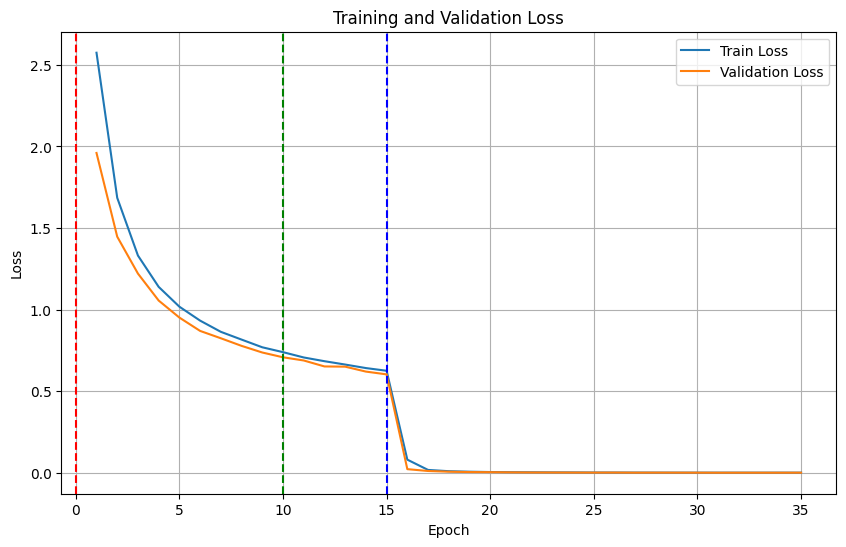

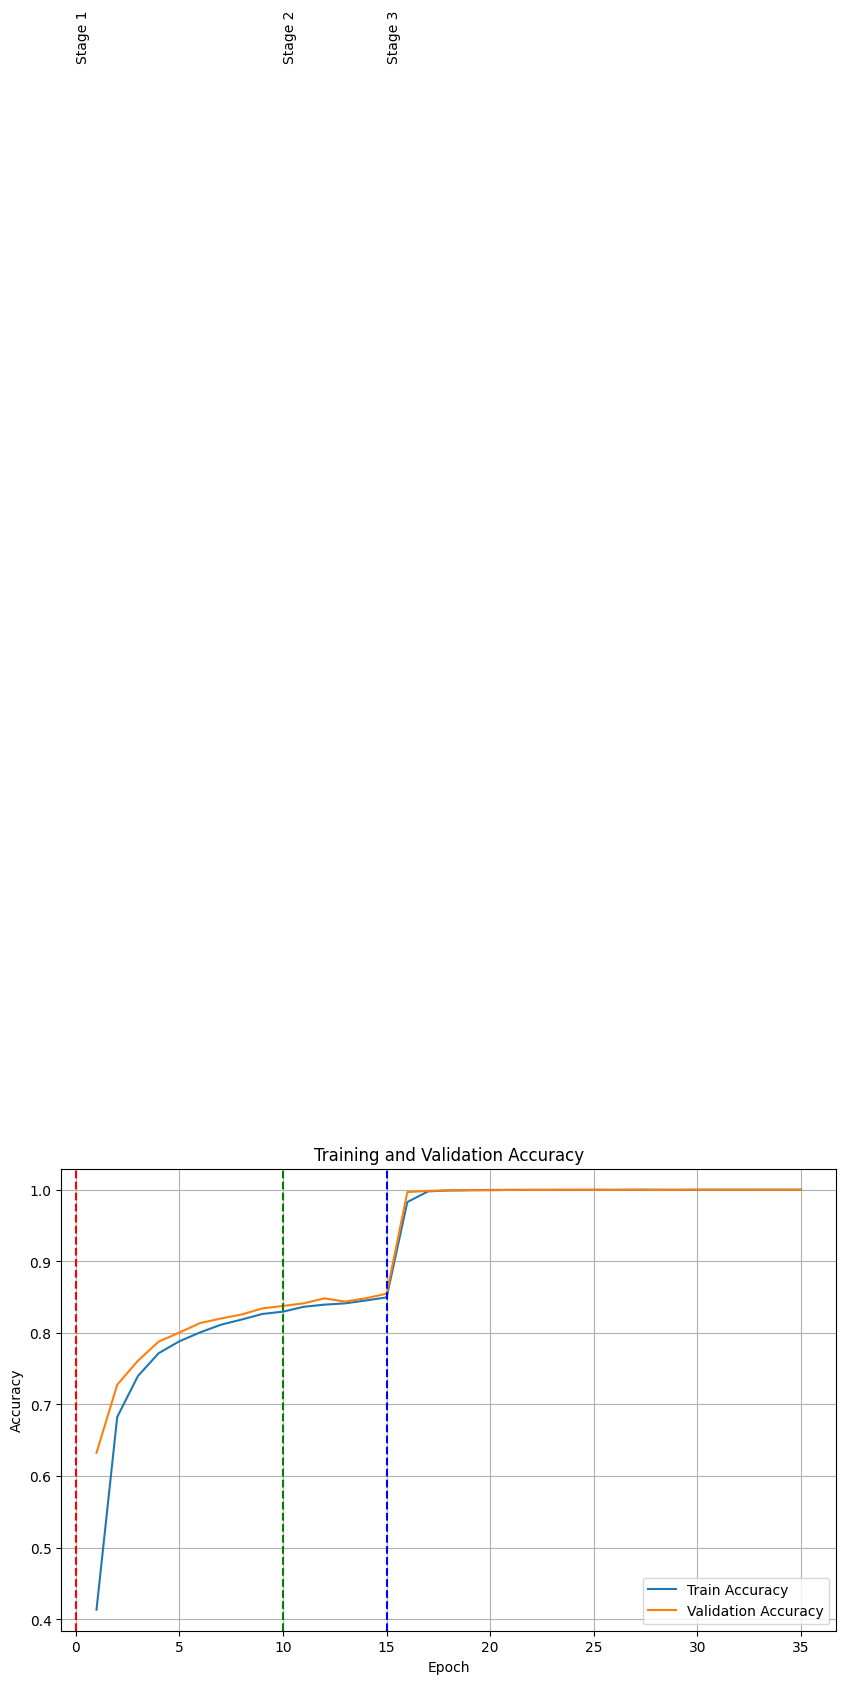

<Figure size 640x480 with 0 Axes>

In [17]:
epochs = np.arange(1, 36)

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Add vertical lines and labels for stages
plt.axvline(x=0, color='r', linestyle='--')  # Vertical line at epoch 0
plt.axvline(x=10, color='g', linestyle='--')  # Vertical line at epoch 10
plt.axvline(x=15, color='b', linestyle='--')  # Vertical line at epoch 15
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Add vertical lines and labels for stages
plt.axvline(x=0, color='r', linestyle='--')  # Vertical line at epoch 0
plt.axvline(x=10, color='g', linestyle='--')  # Vertical line at epoch 10
plt.axvline(x=15, color='b', linestyle='--')  # Vertical line at epoch 15
plt.text(0, max(train_losses), 'Stage 1', rotation=90, verticalalignment='bottom')  # Label for stage 1
plt.text(10, max(train_losses), 'Stage 2', rotation=90, verticalalignment='bottom')  # Label for stage 2
plt.text(15, max(train_losses), 'Stage 3', rotation=90, verticalalignment='bottom')  # Label for stage 3

plt.show()
plt.tight_layout()

## Save model Weights

In [18]:
torch.save(model.state_dict(), 'model_weights.pth')

## Evaluate model on test set

In [19]:
def evaluate_model(model, data_loader):
    model.eval()  # set the model to evaluation mode
    all_predictions = []
    all_labels = []
    incorrect_indices = []  # List to store indices of incorrectly labeled images
    # Disable gradient calculation
    with torch.no_grad():
        for idx, (images, labels) in enumerate(data_loader):
            # Move images and labels to the device
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            # Get the predicted class labels
            _, predictions = torch.max(outputs, 1)

            # Extend the lists with predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Check for incorrect predictions and store their indices
            incorrect_indices.extend(idx * data_loader.batch_size + i 
                                     for i, (pred, true) in enumerate(zip(predictions, labels)) if pred != true)
    return all_predictions, all_labels, incorrect_indices


In [20]:
model.eval()
fine_tuned_predictions, fine_tuned_labels, incorrect_indices = evaluate_model(model, test_loader)

# Calculate accuracy scores
fine_tuned_accuracy = accuracy_score(fine_tuned_labels, fine_tuned_predictions)

print("Fine-tuned model accuracy on testing set:", fine_tuned_accuracy)

# Print the number of incorrectly classified images
print("Number of incorrectly classified images:", len(incorrect_indices))

Fine-tuned model accuracy on testing set: 0.9997701149425288
Number of incorrectly classified images: 3


## Confusion matrix 

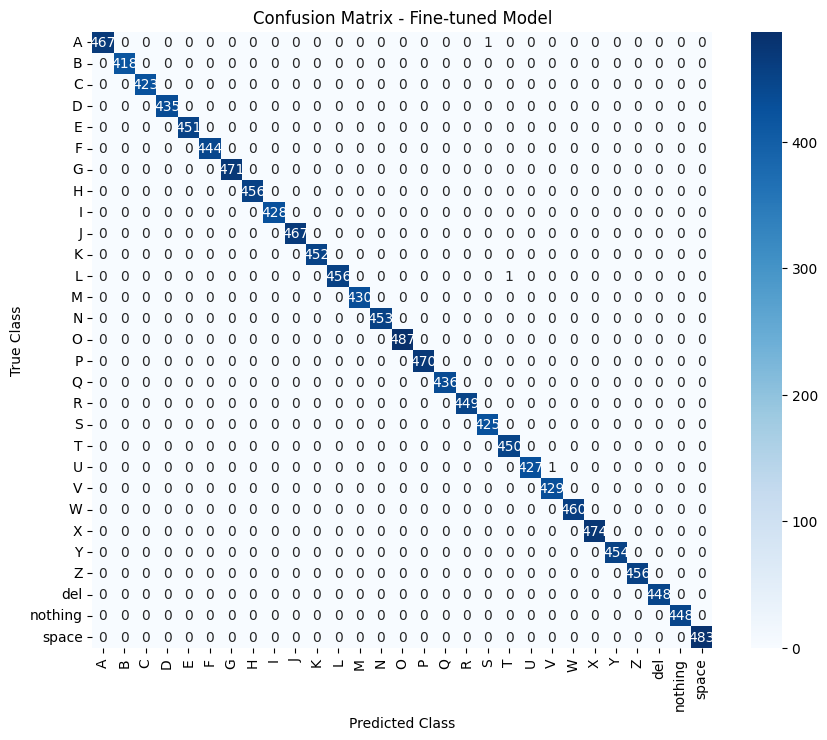

In [21]:
# Generate confusion matrix for the fine-tuned model
fine_tuned_conf_matrix = confusion_matrix(fine_tuned_labels, fine_tuned_predictions)

# Define class names (replace with your own class names if needed)
class_names = class_names

# Plot confusion matrix for the fine-tuned model
plt.figure(figsize=(10, 8))
sns.heatmap(fine_tuned_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Fine-tuned Model")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

## Precision Recall Curve

In [22]:
# Define a function to evaluate the model and get predicted probabilities
def get_predicted_probs_and_labels(model, data_loader):
    model.eval() # Set the model to evaluation mode
    all_probs = []
    all_labels = []
    with torch.no_grad(): # Disable gradient computation
        for images, labels in data_loader: # Iterate through the data loader
            images = images.to(device)  # Move images to the device
            outputs = model(images)  # Forward pass: compute predicted outputs
            probs = torch.softmax(outputs, dim=1)  # Compute softmax probabilities
            all_probs.append(probs.cpu().numpy())  # Convert probabilities to numpy array and append to the list
            all_labels.append(labels.numpy())  # Convert labels to numpy array and append to the list
    return np.concatenate(all_probs), np.concatenate(all_labels)  # Concatenate probabilities and labels


# Compute predicted probabilities for the fine-tuned model on the test data
predicted_probs, true_labels = get_predicted_probs_and_labels(model, test_loader)

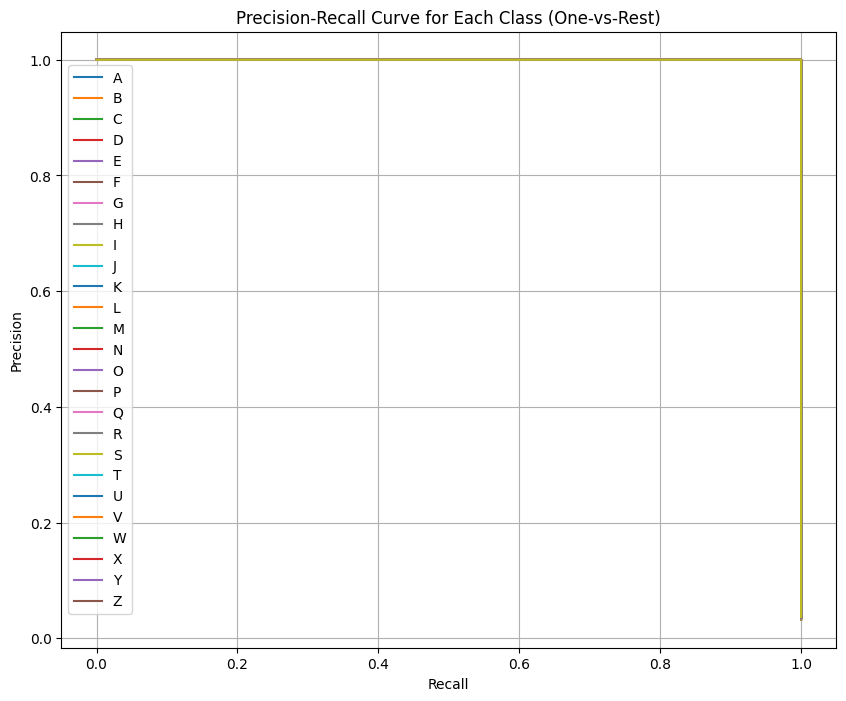

In [23]:
# Convert 'fine_tuned_labels' to one-hot encoded form
binarized_labels = label_binarize(fine_tuned_labels, classes=np.unique(fine_tuned_labels))

# Compute precision-recall pairs for each class
precisions = dict()
recalls = dict()
labels = list(string.ascii_uppercase)
for i in range(num_classes):
    # Compute precision-recall pairs using precision_recall_curve
    precisions[i], recalls[i], _ = precision_recall_curve(binarized_labels[:, i], predicted_probs[:, i])

# Plot precision-recall curves for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recalls[i], precisions[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(labels,loc='center left')
plt.title('Precision-Recall Curve for Each Class (One-vs-Rest)')
plt.grid(True)
plt.show()


## Test on third party test data

In [24]:
test_dir = '/kaggle/input/data-test-extra/test'
# Create the test dataset using ImageFolder
test_dataset_extra = datasets.ImageFolder(root=test_dir, transform=transform)

# Create the test dataloader
test_loader_extra = DataLoader(test_dataset_extra, batch_size=64, shuffle=False)

In [25]:
model.eval() # Set the model to evaluation mode

# Evaluate the fine-tuned model on the additional test data
fine_tuned_predictions_extra, fine_tuned_labels_extra, incorrect_indices_extra = evaluate_model(model, test_loader_extra)

# calculate accuracy scores
fine_tuned_accuracy_extra = accuracy_score(fine_tuned_labels_extra, fine_tuned_predictions_extra)

print("Fine-tuned model accuracy on testing set:", fine_tuned_accuracy_extra)
print("Number of incorrectly classified images:", len(incorrect_indices_extra))

Fine-tuned model accuracy on testing set: 0.34528143377205267
Number of incorrectly classified images: 2338


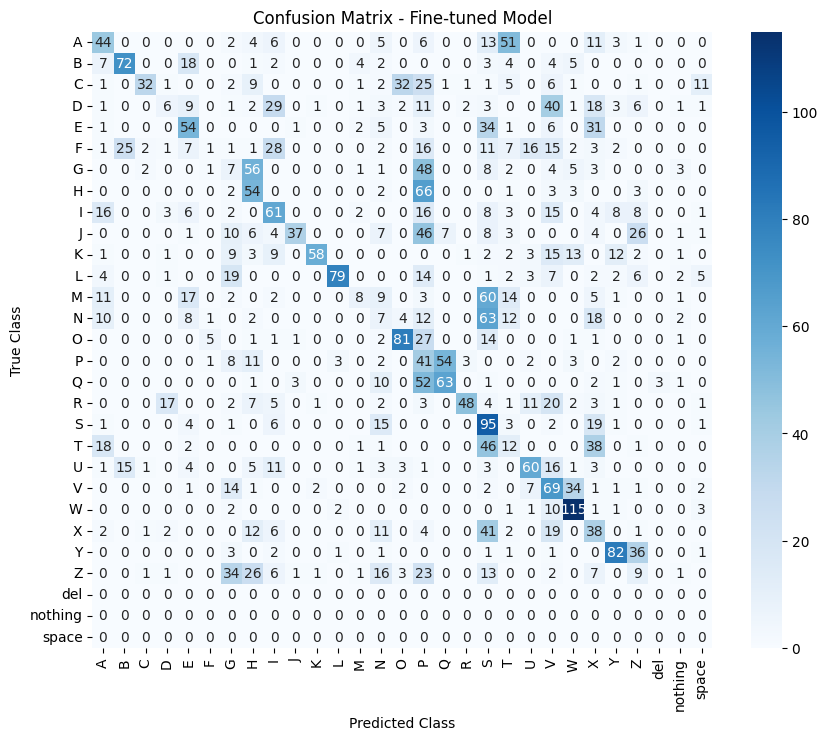

In [26]:
# Generate confusion matrix for the fine-tuned model
fine_tuned_conf_matrix_extra = confusion_matrix(fine_tuned_labels_extra, fine_tuned_predictions_extra)

# Define class names (replace with your own class names if needed)
class_names = class_names

# Plot confusion matrix for the fine-tuned model
plt.figure(figsize=(10, 8))
sns.heatmap(fine_tuned_conf_matrix_extra, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Fine-tuned Model")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [28]:
predicted_probs_extra, true_labels_extra = get_predicted_probs_and_labels(model, test_loader_extra)

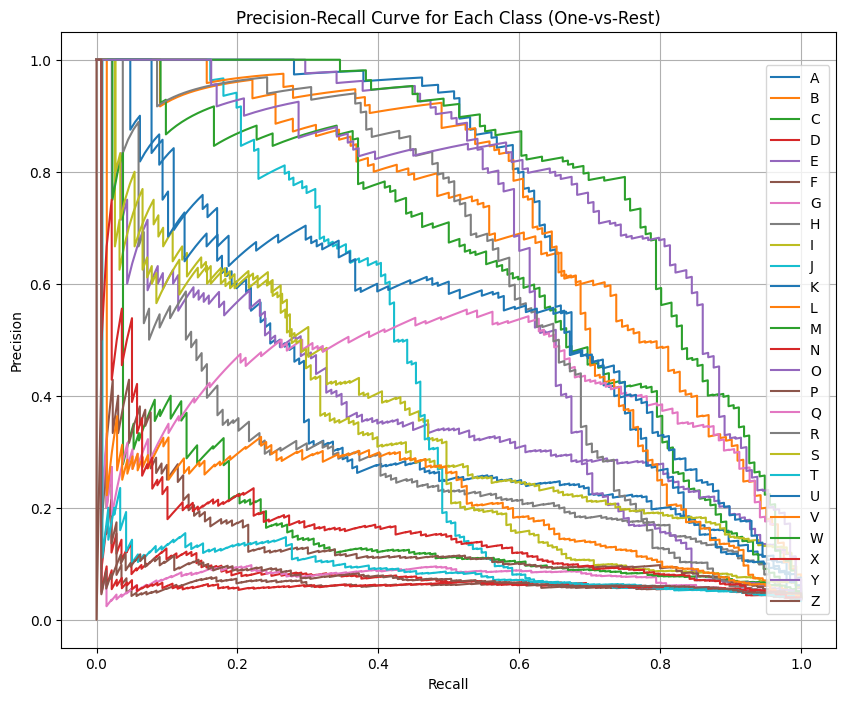

In [29]:
# Convert 'fine_tuned_labels' to one-hot encoded form
binarized_labels_extra = label_binarize(fine_tuned_labels_extra, classes=np.unique(fine_tuned_labels_extra))

# Compute precision-recall pairs for each class
precisions_extra = dict()
recalls_extra = dict()
labels = list(string.ascii_uppercase)
num_classes_to_use = binarized_labels_extra.shape[1]
for i in range(num_classes_to_use):
    precisions_extra[i], recalls_extra[i], _ = precision_recall_curve(binarized_labels_extra[:, i], predicted_probs_extra[:, i])

# Plot precision-recall curves for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes_to_use):
    plt.plot(recalls_extra[i], precisions_extra[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class (One-vs-Rest)')
plt.legend(labels,loc='right')
plt.grid(True)
plt.show()


## View which subset of images which were classified incorrectly

28 3571 3571 28
Number of incorrect indices: 28
Index: 1588
Length of images list: 28
Index: 3390
Length of images list: 28
Index: 2628
Length of images list: 28
Index: 851
Length of images list: 28
Index: 751
Length of images list: 28
Index: 3441
Length of images list: 28
Index: 1160
Length of images list: 28
Index: 1099
Length of images list: 28
Index: 893
Length of images list: 28
Index: 3366
Length of images list: 28
Index: 3227
Length of images list: 28
Index: 1907
Length of images list: 28
Index: 3001
Length of images list: 28
Index: 3525
Length of images list: 28
Index: 3161
Length of images list: 28
Index: 1178
Length of images list: 28
Index: 3528
Length of images list: 28
Index: 1283
Length of images list: 28
Index: 3290
Length of images list: 28
Index: 2990
Length of images list: 28
Index: 633
Length of images list: 28
Index: 3382
Length of images list: 28
Index: 402
Length of images list: 28
Index: 1040
Length of images list: 28
Index: 1532
Length of images list: 28
Index: 

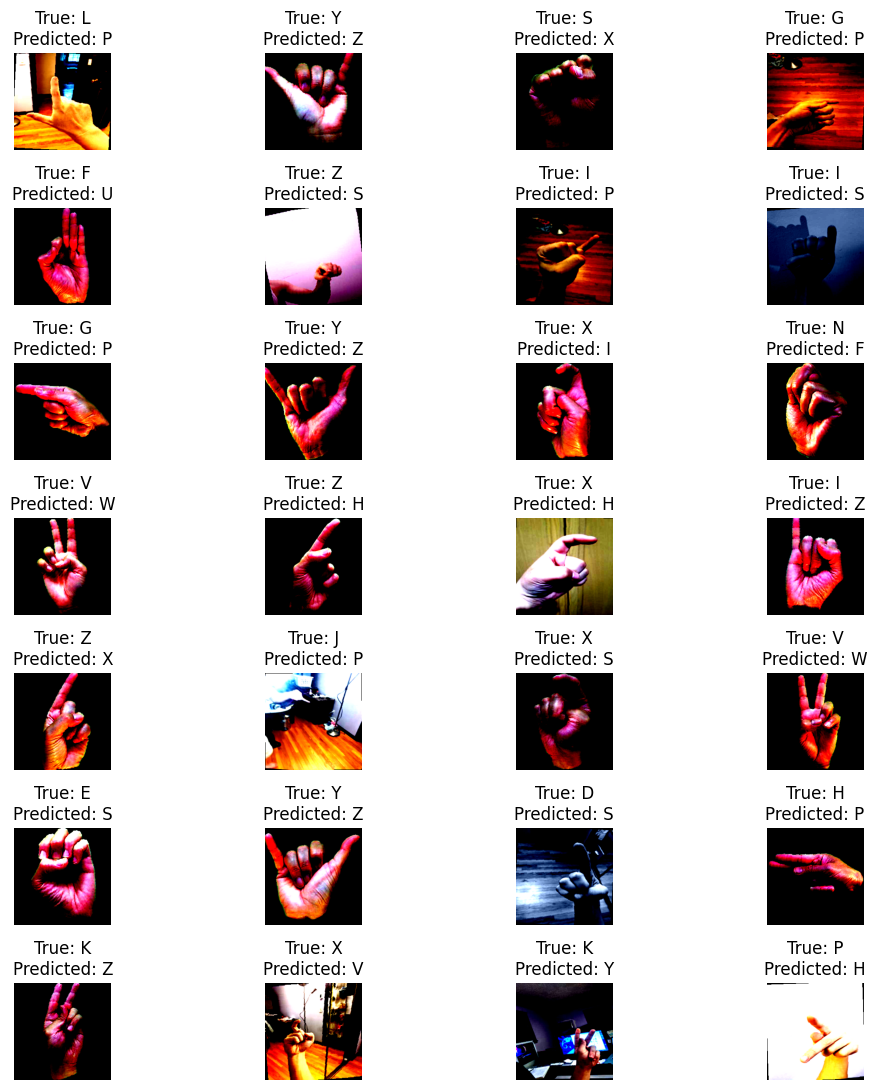

In [62]:
def show_images(images, labels, predicted_labels, incorrect_indices, class_names):
    print(len(images), len(labels), len(predicted_labels), len(incorrect_indices))
    fig = plt.figure(figsize=(11, 11))
    columns = 4
    rows = 7 

    print("Number of incorrect indices:", len(incorrect_indices))

    # Iterate over each incorrect index and display corresponding image
    for i, idx in enumerate(incorrect_indices):
        print("Index:", idx)
        print("Length of images list:", len(images))
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.set_title(f"True: {class_names[labels[idx]]}\nPredicted: {class_names[predicted_labels[idx]]}")
        ax.axis('off')


    plt.tight_layout()
    plt.show()

num_images_to_display = 28  # Number of images to display

# Randomly select num_images_to_display incorrect indices
random_incorrect_indices = random.sample(incorrect_indices_extra, num_images_to_display)

# Collect images corresponding to the randomly selected incorrect indices
images = []
for idx in random_incorrect_indices:
    try:
        image, _ = test_dataset_extra[idx]
        images.append(image)
    except IndexError:
        print(f"IndexError occurred for index: {idx}")

class_names = labels

show_images(images, fine_tuned_labels_extra, fine_tuned_predictions_extra, random_incorrect_indices, class_names)
